torch.Size([2, 1, 25, 179])


FloatProgress(value=0.0, max=19.0)

448723.2250289917
437250.59830474854
419379.6398200989
399080.6605796814
389821.60997772217
384135.4709663391
377804.86403656006
372702.2752132416
366118.4210739136
363073.36064338684
359320.43171691895
354065.1032962799
352549.65853881836
347603.6720638275
346968.6004257202
342532.10414886475
338626.65839767456
337103.21779060364
332412.2739677429
329491.0784072876


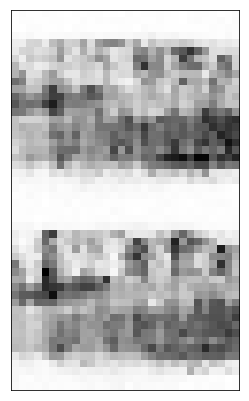

Wall time: 583 ms


In [30]:
%%time
from __future__ import print_function
import math
import matplotlib.cm as cm
from matplotlib import pyplot as plt

# ADD: for the nice progress bar
from ipywidgets import FloatProgress
from IPython.display import display

import numpy as np
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
from random import randint

import numpy as np
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import pyro
from pyro.optim import Adam
from pyro.infer import SVI
import pyro.distributions as pdist
import torch.distributions as tdist
import torch.distributions.constraints as constraints
import pyro.infer
from pyro.infer import SVI, Trace_ELBO,  TraceGraph_ELBO
import pyro.optim

%matplotlib inline

# torch.manual_seed(101)

flag_ISM = 0
overlap_flag = 0
noisy_flag = 1
nw = 25  # number of words 25
ntr = 30  # number of relative times in a motif 70
nd = 2  # number of documents 
Td= 150 # number of time period
nz = 2


#-----------------------------------------------------------------
plt.rc('figure', figsize=(12.0, 7.0))
def get_size(txt, font):
    test_img = Image.new('L', (1, 1))
    test_draw = ImageDraw.Draw(test_img)
    return test_draw.textsize(txt, font)

def string_to_matrix(s, fontname, fontsize, nw, ntr):
    # Define the Text Color and the Background
    color_text = "White"
    color_background = "Black"
    # Define the image font and resize the nword in a rectangle that suit it
    text = s
    font = ImageFont.truetype(fontname, fontsize)
    width, height = get_size(text, font)
    img = Image.new('L', (ntr, nw), color_background)
    d = ImageDraw.Draw(img)
    d.text((3, height / 10), text, fill=color_text, font=font)
    #d.rectangle((0, 0, width, height))
    path = 'Image_' + text + '.png'
    img.save(path)
    im = Image.open(path).convert('L')
    motif = np.asarray(im, np.float32)  # Motif Matrix
    return motif

# motifs_as_string = ["eggplop", "eggnog", "eggplant", "banana", "apple"]
motifs_as_string = ["WYX", "Crab","HJQ"]

nz0 = len(motifs_as_string)

fontname = 'JennaSue.ttf'
fontsize = 25

motifs_as_matrix = [string_to_matrix(st, fontname, fontsize, nw, ntr) for st in motifs_as_string]

# CHANGE: simplified using
motifs = torch.stack([ torch.tensor(m[np.newaxis, :, :]) for m in motifs_as_matrix ], 0).cuda()

# ADD: number of documents

z = torch.zeros(nd,nz0,1,Td).cuda()

# the following tries to generate the clean data(patterns are clear, no overlao)
#clear version
if overlap_flag == 0:
    z[0,0,0,1]=1
    z[0,1,0,99]=1
    z[0,2,0,30]=1
    z[0,2,0,70]=1
    z[0,0,0,149]=1

    z[1,2,0,90]=1
    z[1,2,0,10]=1
    z[1,1,0,40]=1
    z[1,0,0,120]=1
    z[1,1,0,140]=1
elif overlap_flag == 1:
    #overlap version
    z[0,0,0,20]=1
    z[0,2,0,99]=1
    z[0,1,0,30]=1
    z[0,2,0,70]=1
    z[0,1,0,110]=1
    z[0,0,0,149]=1

    z[1,2,0,90]=1
    z[1,2,0,10]=1
    z[1,1,0,20]=1
    z[1,0,0,120]=1
    z[1,1,0,130]=1
elif overlap_flag == 2:
    #overlap version
    z[0,0,0,20]=1
    z[0,2,0,99]=1
    z[0,1,0,25]=1
    z[0,2,0,70]=1
    z[0,1,0,60]=1
    z[0,1,0,110]=1
    z[0,2,0,130]=1
    z[0,0,0,149]=1

    z[1,2,0,90]=1
    z[1,1,0,85]=1
    z[1,2,0,10]=1
    z[1,1,0,20]=1
    z[1,0,0,50]=1
    z[1,1,0,60]=1
    z[1,0,0,120]=1
    z[1,1,0,130]=1
elif overlap_flag == 3:
    #overlap version
    z[0,0,0,10]=1
    z[0,1,0,20]=1
    z[0,2,0,45]=1
    z[0,1,0,69]=1
    z[0,0,0,80]=1
    z[0,2,0,110]=1
#     z[0,1,0,140]=1
    
    z[1,2,0,10]=1
    z[1,1,0,20]=1
    z[1,0,0,50]=1
    z[1,1,0,60]=1
    z[1,2,0,90]=1
#     z[1,0,0,130]=1
#     z[1,1,0,110]=1

# CHANGE: rename to avoid conflict with a defined variable later
p_w_ta_d0 = F.conv_transpose2d(z,motifs).cuda()
# CHANGE: use (-1) as a shape to let it infer the size
print(p_w_ta_d0.shape)
p_w_ta_d0 = p_w_ta_d0.view(-1)

# CHANGE: don't sample but rather "get the average"
data = 1 * p_w_ta_d0
N = data.sum()

# generate document with Gaussian noisy points
def noisy_doc(data):
    s1,s2 = int(len(data)/ (Td+ntr-1)), int(Td+ntr-1)
    means=torch.zeros(s1,s2)
    std = torch.ones(s1,s2)
    sigma = 0
    std = std*sigma
    noise = torch.normal(means, std).cuda()
    nnoise = noise.cpu().numpy()
    noisy_data = torch.from_numpy(data.cpu().numpy() + nnoise.reshape(1,-1)).cuda()
    return noisy_data

if noisy_flag:
    data = noisy_doc(data)
    data = data.abs()
    tem_data = np.abs(data.reshape(-1, Td+ntr-1).cpu()).numpy().astype(np.int32)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(-tem_data.reshape(-1, Td+ntr-1),cmap = "gray")
    plt.savefig("abc.png")
else:
    plt.xticks([])
    plt.yticks([])
    plt.imshow(-data.reshape(-1, Td+ntr-1).cpu(),cmap = "gray")
    plt.savefig("abc.png")

def p_w_ta_d(z,motifs):
    t = F.conv_transpose2d(z,motifs)
    return t.view(-1)
# ADD: introduce some variables
prior0 = 0.1*N/nd / nz / Td
prior1 = 0.1*N/nz / nw / ntr
#randinit = 0

def model(data):
    s0 = (nd, nz, 1, Td)
    s1 = (nz, 1, nw, ntr)
    alpha0 = torch.ones(*s0).cuda()
    alpha1 = torch.ones(*s1).cuda()
    z = pyro.sample("latent0", pdist.Dirichlet(concentration=alpha0.view(nd, -1)))
    motifs = pyro.sample("latent1", pdist.Dirichlet(concentration=alpha1.view(nz, -1)))

    z = z.reshape(*s0)
    motifs = motifs.reshape(*s1)
    p = p_w_ta_d(z, motifs)
    with pyro.iarange("data", len(data)):
        zts = pyro.sample("zts", pdist.Categorical(probs=z))
        pyro.sample("observe", pdist.Multinomial(probs=p), obs=data)

# Give the initialization

step_motif_count = 0
tem_motif = []

def guide(data):
    qalpha0 = pyro.param("qalpha0", torch.ones(nd,nz,1,Td).cuda(), constraint=constraints.positive) # z_ts table
    global step_motif_count
    if flag_ISM:
        qalpha1 = pyro.param("qalpha1", init_motif, constraint=constraints.positive) # motif
        if step_motif_count%5 == 0:
            tem_motif.append(qalpha1)
    else:
        qalpha1 = pyro.param("qalpha1",  torch.ones(nz,1,nw,ntr).cuda(), constraint=constraints.positive) # motif
        if step_motif_count%5 == 0:
            tem_motif.append(qalpha1)
            
#     CHANGE: use the fact that dirichlet can draw independant dirichlets
    pyro.sample("latent0",pdist.Dirichlet(concentration=qalpha0.view(nd, -1)))
    pyro.sample("latent1",pdist.Dirichlet(concentration=qalpha1.view(nz, -1)))
def show_motifs():
    infer_motifs = np.load("qalpha1.npy")
    for i in range(nz):
        plt.figure(i)
        locals()['infer_motif' +str(i)] = infer_motifs[i,0,:,:]
        plt.imshow(-locals()['infer_motif' +str(i)],cmap = "gray") 
        plt.xticks([])
        plt.yticks([])
        plt.savefig("%d.jpg"%(i+1))
        plt.show()
def show_real_motifs():
    for i in range(nz):
        plt.figure(i)
        locals()['real_motif' +str(i)] =  motifs[0,0,:,:].cpu().numpy()
        plt.imshow(-locals()['real_motif' +str(i)],cmap = "gray")
        plt.xticks([])
        plt.yticks([])
        plt.show()
# CHANGE: change adam params
pyro.clear_param_store()
adam_params = {"lr": 0.1}
optimizer = pyro.optim.Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps = 20
pro = FloatProgress(min=0, max=n_steps-1)
display(pro)
# data_cuda = data.cuda()

for step in range(n_steps):
    loss = svi.step(data)
    print(loss)
    pro.value += 1
    pro.description = str(step)
    
# CHANGE: change only at the end
np.save(file="qalpha0",arr=pyro.param("qalpha0").detach().cpu().numpy())
np.save(file="qalpha1",arr=pyro.param("qalpha1").detach().cpu().numpy())

# ADD: quick plot before exhaustive plot
loaded = np.load("qalpha1.npy")
plt.imshow( -loaded.reshape(-1, ntr), cmap="gray")
plt.show()
# show_motifs()

In [2]:
445291.48122406006
425226.45282554626
397108.21576690674
380576.67636585236
371468.4277687073
361496.34244155884
361045.30221939087
351890.16150283813
349601.4594039917
347817.4319381714

FloatProgress(value=0.0, max=499.0)

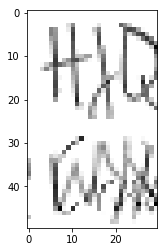

Wall time: 26 s


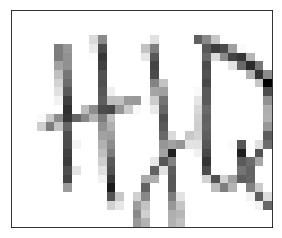

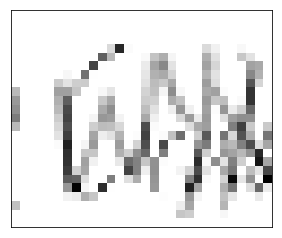

In [4]:
show_motifs()